<a href="https://colab.research.google.com/github/Gunjan712Sehrawat/titanic_kmeans_pca/blob/main/titanic_kmeans_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

'''Titanic – Unsupervised Clustering with K-Means and PCA.

In this project, we apply unsupervised machine learning to the Titanic dataset to explore natural passenger groupings without using survival information.

We use K-Means for clustering and PCA for visualization.'''


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
import joblib
np.random.seed(42)


In [6]:
# Load dataset

df = sns.load_dataset('titanic')
df.shape, df.head(3)


((891, 15),
    survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
 0         0       3    male  22.0      1      0   7.2500        S  Third   
 1         1       1  female  38.0      1      0  71.2833        C  First   
 2         1       3  female  26.0      0      0   7.9250        S  Third   
 
      who  adult_male deck  embark_town alive  alone  
 0    man        True  NaN  Southampton    no  False  
 1  woman       False    C    Cherbourg   yes  False  
 2  woman       False  NaN  Southampton   yes   True  )

Missing values:
 survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


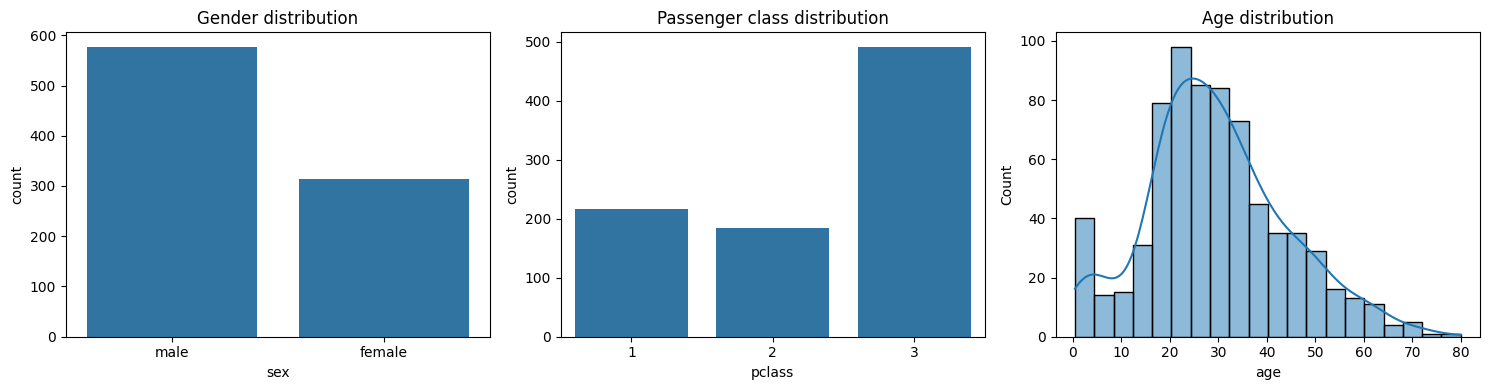

In [16]:
# EDA – Quick Insights

# Missing values
print("Missing values:\n", df.isnull().sum())

# Basic distributions
fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.countplot(x='sex', data=df, ax=axes[0])
sns.countplot(x='pclass', data=df, ax=axes[1])
sns.histplot(df['age'], bins=20, kde=True, ax=axes[2])

axes[0].set_title('Gender distribution')
axes[1].set_title('Passenger class distribution')
axes[2].set_title('Age distribution')

plt.tight_layout()
plt.show()


In [17]:
# Feature Selection & Preprocessing

features = ['pclass','sex','age','sibsp','parch','fare','embarked']
X = df[features].copy()

num_features = ['age','sibsp','parch','fare','pclass']
cat_features = ['sex','embarked']

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

X_prep = preprocessor.fit_transform(X)
print("Prepared data shape:", X_prep.shape)



Prepared data shape: (891, 10)


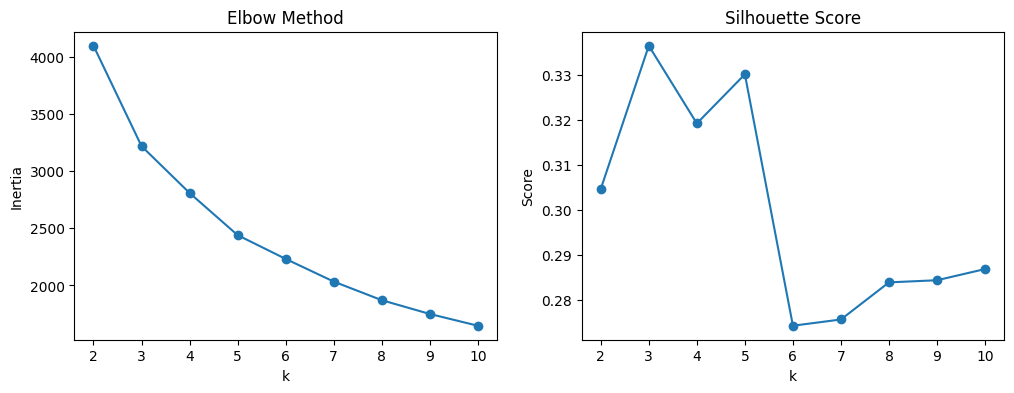

In [18]:
# Choosing k – Elbow & Silhouette

inertia = []
sil_scores = []
K_range = range(2,11)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_prep)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_prep, labels))

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(list(K_range), inertia, '-o')
ax[0].set_title('Elbow Method'); ax[0].set_xlabel('k'); ax[0].set_ylabel('Inertia')

ax[1].plot(list(K_range), sil_scores, '-o')
ax[1].set_title('Silhouette Score'); ax[1].set_xlabel('k'); ax[1].set_ylabel('Score')
plt.show()


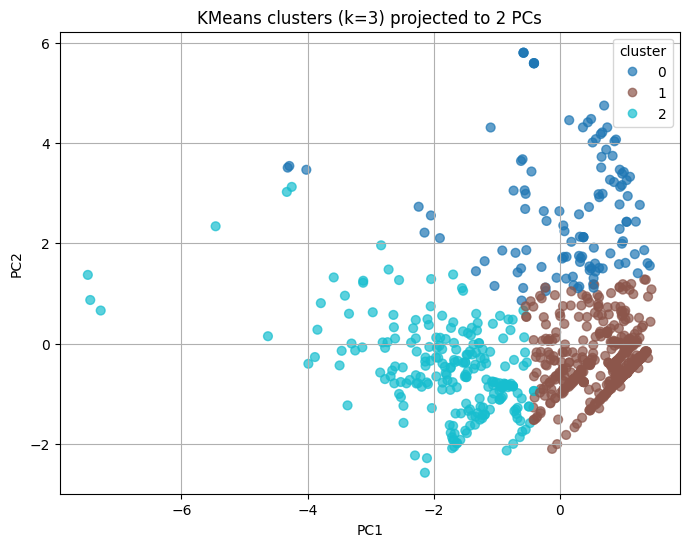

<Figure size 640x480 with 0 Axes>

In [21]:
k_chosen = 3   # <-- change after inspecting elbow/silhouette
km = KMeans(n_clusters=k_chosen, n_init=10, random_state=42)
cluster_labels = km.fit_predict(X_prep)

# PCA to 2D for plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_prep)

plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels, cmap='tab10', alpha=0.7, s=40)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title(f'KMeans clusters (k={k_chosen}) projected to 2 PCs')
plt.legend(*sc.legend_elements(), title="cluster")
plt.grid(True)
plt.show()



In [22]:
# Cluster Interpretation Table
# Cluster 0: higher fare, older passengers, likely 1st class

df_clusters = X.copy()
df_clusters['cluster'] = cluster_labels
summary = df_clusters.groupby('cluster').agg({
    'pclass':'mean',
    'age':'mean',
    'sibsp':'mean',
    'parch':'mean',
    'fare':'mean'
})
print(summary)


           pclass        age     sibsp     parch       fare
cluster                                                    
0        2.594828  13.867500  2.189655  1.931034  40.341989
1        2.757798  28.156812  0.227523  0.088073  12.306895
2        1.100000  40.807500  0.382609  0.295652  75.247917


In [23]:
#Save Artifacts & Results

joblib.dump(km, 'kmeans_model.joblib')
joblib.dump(preprocessor, 'preprocessor.joblib')
joblib.dump(pca, 'pca_2d.joblib')

with open('RESULTS.md','w') as f:
    f.write("Titanic KMeans+PCA results\n")
    f.write(f"Chosen k: {k_chosen}\n")
print("Wrote RESULTS.md")
!cat RESULTS.md


Wrote RESULTS.md
Titanic KMeans+PCA results
Chosen k: 3


In [24]:
!ls -l RESULTS.md


-rw-r--r-- 1 root root 39 Aug 12 11:49 RESULTS.md


In [25]:
from google.colab import files
files.download('RESULTS.md')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
import os

os.makedirs('data', exist_ok=True)
os.makedirs('figs', exist_ok=True)
os.makedirs('notebooks', exist_ok=True)

# Save figure
plt.savefig(f'kmeans_pca_k{k_chosen}.png', bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

## 📌 Conclusion
We successfully applied unsupervised learning to the Titanic dataset, identifying **3 distinct passenger clusters** based on ticket class, fare, age, and other features.  
PCA visualization clearly shows separation between clusters, suggesting that passenger characteristics naturally group in meaningful ways, even without survival labels.

In [28]:
# Create .gitignore file
gitignore_content = """# Ignore Python cache files
__pycache__/
*.pyc

# Ignore notebook checkpoints
.ipynb_checkpoints/

# Ignore CSV and large data files
*.csv
data/

# Ignore system files
.DS_Store
"""

with open(".gitignore", "w") as f:
    f.write(gitignore_content)

print(".gitignore created!")


.gitignore created!
